# Conservation of invariants and code stability

This notebook aims at investigation the stability of the code as a function of input parameters and the conservation of invariants such as energy and momentum.


In [49]:
# some preliminary settings and functions

import sys
sys.path.append("/home/aunai/build_phare")
sys.path.append("/home/aunai/PHARE/pyphare/")
import os
import numpy as np
import pyphare
from pyphare.pharesee.hierarchy import finest_data
from pyphare.pharesee.hierarchy import hierarchy_from
from pyphare.pharesee.plotting import zoom_effect
import matplotlib.pyplot as plt
from pyphare.pharesee.run import Run
from dispersion import get_times
from pyphare.pharesee.hierarchy import merge_particles
%matplotlib notebook


In [155]:
def plot_job(job, time, qty,**kwargs):
    path = job
    r = Run(path)
    t=time        
    B = r.GetB(t)
    #N = r.GetNi(t)
    #V = r.GetVi(t)
    if qty in ("Bx","By","Bz"):
        self = B
    if qty == "rho":
        self = N
    if qty in ("Vx", "Vy", "Vz"):
        self = V
    fig, (ax1,ax2) = plt.subplots(nrows=2, figsize=(8,6), sharex=True)
    colors = ["k", "b", "r"]
    for ilvl, lvl in self.patch_levels.items():
        for pidx, patch in enumerate(lvl.patches):
            pdata  = patch.patch_datas[qty]
            x,v = finest_data(pdata, ilvl, self)
            ax1.plot(x, v,label="lev{} - patch{}".format(ilvl, pidx),
                     marker='o', markersize=2, color=colors[ilvl])

    for ilvl,level in B.patch_levels.items():
        for patch in level.patches:
            dx = patch.dx
            x0 = patch.origin[0]
            x1 = (patch.box.upper[0]+1)*dx
            ax2.axvspan(x0, x1, color='b',ec='k', alpha=0.2,
                        ymin=ilvl/4, ymax=(ilvl+1)/4)

    ax1.set_title("{} at t = {}".format(job,t))

    ax1.set_ylim(kwargs.get("ylim",(-3.5, 3.5)))

    ax1.set_xlim(kwargs.get("xlim", (0,500)))

    return fig, ax1, ax2

In [294]:
def kinetic_energy(particles):
    return 0.5*np.sum((particles.v[:,0]**2 + particles.v[:,1]**2 + particles.v[:,2]**2)* particles.weights)

def momentum(particles):
    m = 1
    return m*np.asarray([np.sum(v*particles.weights) for v in [particles.v[:,0], particles.v[:,1], particles.v[:,2]]])

In [296]:
def total_particles(parts, fun, lvlNbr=0):
    for ilvl, lvl in parts.patch_levels.items():
        if lvlNbr == ilvl:
            tot = 0.
            for ip, patch in enumerate(lvl.patches):
                keys = list(patch.patch_datas.keys())
                pdata = patch.patch_datas[keys[0]]
                particles= pdata.dataset
                per_patch = fun(particles)
                tot += per_patch
    return tot    

In [297]:
def total_kinetic(parts, lvlNbr=0):
    return total_particles(parts, kinetic_energy, lvlNbr)

def total_momentum(parts, lvlNbr=0):
    return total_particles(parts, momentum, lvlNbr)

def mag_energy(B, lvlNbr=0):
    for ilvl, lvl in B.patch_levels.items():
        if lvlNbr == ilvl:
            tot = 0.
            for ip, patch in enumerate(lvl.patches):
                bx = patch.patch_datas["Bx"].dataset[5:-5]
                bytmp = patch.patch_datas["By"].dataset[4:-4]
                bztmp = patch.patch_datas["Bz"].dataset[4:-4]
                by = 0.5*(bytmp[1:]+bytmp[:-1])
                bz = 0.5*(bztmp[1:]+bztmp[:-1])
                per_patch = np.sum(bx**2 + by**2 + bz**2)*0.5
                tot +=  per_patch
        return tot

## run001 : test run to load and plot particle data

The run has a uniform density n=1, B=Bx=1, Vth=0.3, there are 400 cells with 100 particles per cell. See [input script](/home/aunai/phare_jobs/tests/conservation/run001/conserv.py)

In [298]:
r = Run("/home/aunai/phare_jobs/tests/conservation/run001/")

We load domain particles

In [299]:
prodom = r.GetParticles(0, "protons")

In [300]:
total_kinetic(prodom)

10.789654731750488

In [290]:
total_momentum(prodom)

array([ 0.0353626 , -0.02751559,  0.00895173], dtype=float32)

In [291]:
def get_all(parthier):
    import copy
    final = None
    for ip,p in enumerate(parthier.patch_levels[0].patches):
        part = p.patch_datas["protons_domain"]
        if final is None:
            final = copy.copy(part.dataset)
        else:
            final.add(part.dataset)
    return final

In [292]:
p2 = get_all(prodom)

In [293]:
0.5*np.sum(p2.v[:,0]**2 + p2.v[:,1]**2 + p2.v[:,2]**2)*0.002

10.789654296875

In [301]:
times = get_times(r.path+"/EM_B.h5")

In [302]:
Bnrj = np.zeros_like(times)
K = np.zeros_like(times)
for it,t in enumerate(times):
    B = r.GetB(t)
    protons = r.GetParticles(t, "protons")
    Bnrj[it] = mag_energy(B)
    K[it] = total_kinetic(protons)

<IPython.core.display.Javascript object>


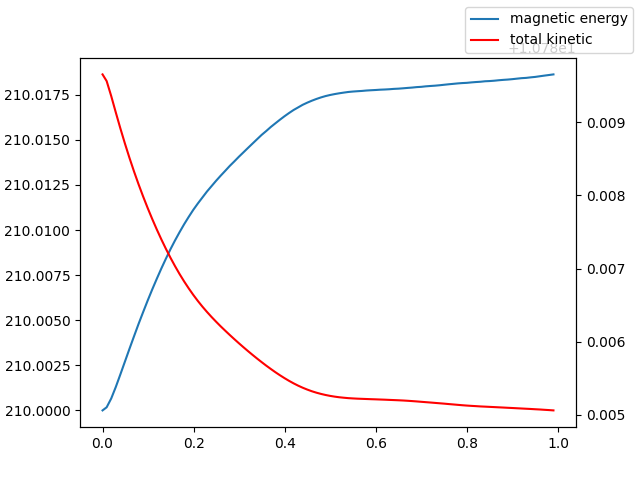

In [303]:
fig, ax1 =plt.subplots()
ax1.plot(times, Bnrj, label="magnetic energy")
ax2 = plt.twinx(ax1)
ax2.plot(times, K, label="total kinetic", color="r")
fig.legend()
#ax.set_yscale("log")

<IPython.core.display.Javascript object>


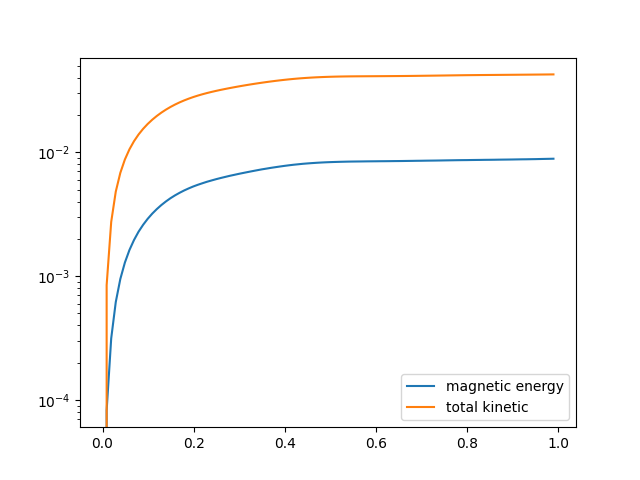

In [304]:
fig, ax = plt.subplots()
ax.plot(times, np.abs(Bnrj-Bnrj[0])/Bnrj[0]*100, label="magnetic energy")
ax.plot(times, np.abs(K-K[0])/K[0]*100, label="total kinetic")
ax.legend()
ax.set_yscale("log")

In [305]:
mom = np.zeros_like(times)
for it,t in enumerate(times):
    protons = r.GetParticles(t, "protons")
    P = total_momentum(protons)
    mom[it] = np.sqrt(P[0]**2 + P[1]**2 + P[2]**2)

<IPython.core.display.Javascript object>


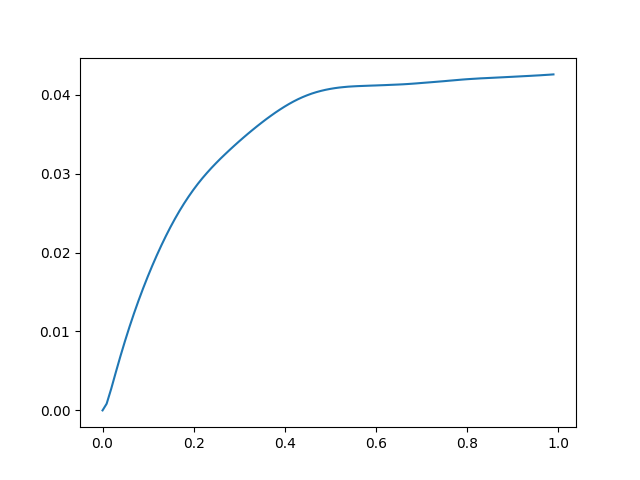

In [306]:
fig, ax = plt.subplots()
ax.plot(times,np.abs(K-K[0])/K[0]*100)

<IPython.core.display.Javascript object>


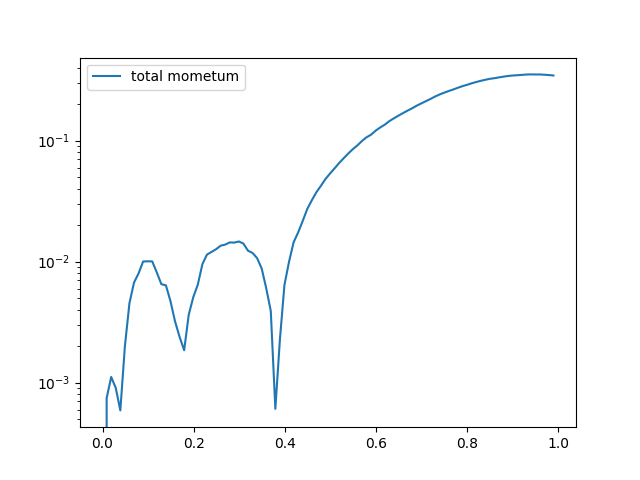

In [307]:
fig, ax = plt.subplots()
ax.plot(times, np.abs(mom - mom[0])/mom[0]*100, label="total mometum")
ax.legend()
ax.set_yscale("log")

<IPython.core.display.Javascript object>


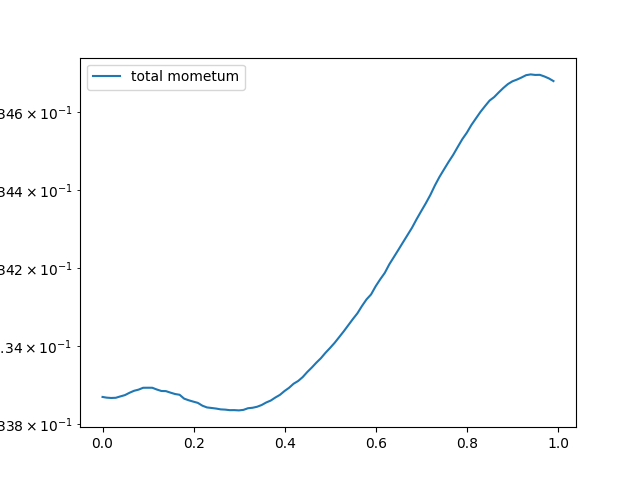

In [308]:
fig, ax = plt.subplots()
ax.plot(times, mom, label="total mometum")
ax.legend()
ax.set_yscale("log")

##  Run002

In [309]:
r = Run("/home/aunai/phare_jobs/tests/conservation/run002/")

In [310]:
times = get_times(r.path+"/EM_B.h5")

In [311]:
Bnrj = np.zeros_like(times)
K = np.zeros_like(times)
for it,t in enumerate(times):
    B = r.GetB(t)
    protons = r.GetParticles(t, "protons")
    Bnrj[it] = mag_energy(B)
    K[it] = total_kinetic(protons)

<IPython.core.display.Javascript object>


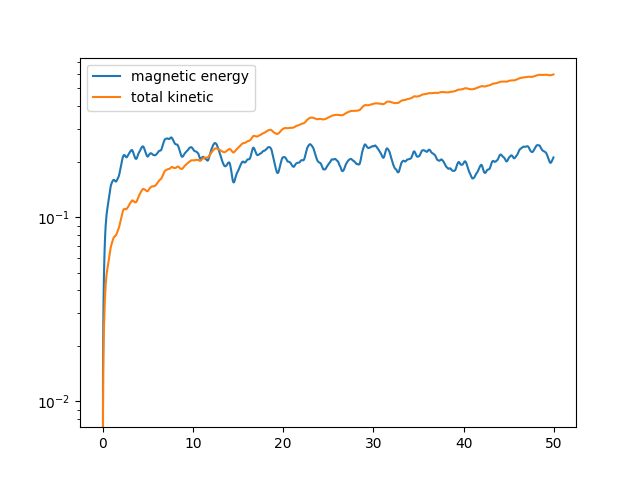

In [321]:
fig, ax = plt.subplots()
ax.plot(times, np.abs(Bnrj-Bnrj[0])/Bnrj[0]*100, label="magnetic energy")
ax.plot(times, np.abs(K-K[0])/K[0]*100, label="total kinetic")
ax.legend()
ax.set_yscale("log")

In [328]:
from scipy.ndimage import gaussian_filter1d as gf

<IPython.core.display.Javascript object>


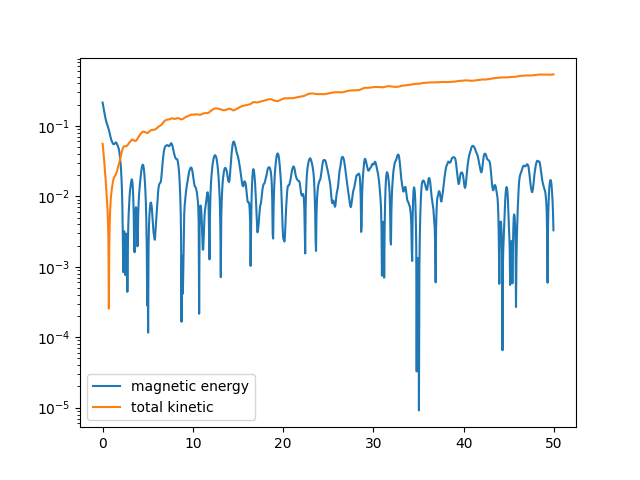

In [338]:
fig, ax = plt.subplots()
ax.plot(times, np.abs(Bnrj-210.45)/210.45*100, label="magnetic energy")
ax.plot(times, np.abs(gf(K,sigma=1)-120.2)/120.2*100, label="total kinetic")
ax.legend()
ax.set_yscale("log")

<IPython.core.display.Javascript object>


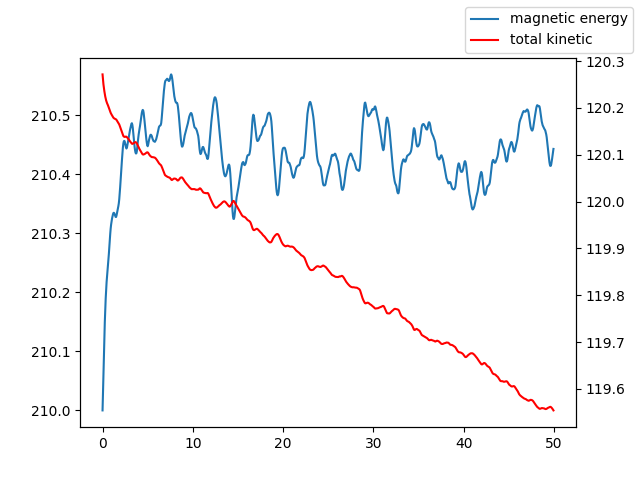

In [325]:
fig, ax1 =plt.subplots()
ax1.plot(times, Bnrj, label="magnetic energy")
ax2 = plt.twinx(ax1)
ax2.plot(times, K, label="total kinetic", color="r")
fig.legend()
#ax.set_yscale("log")

<IPython.core.display.Javascript object>


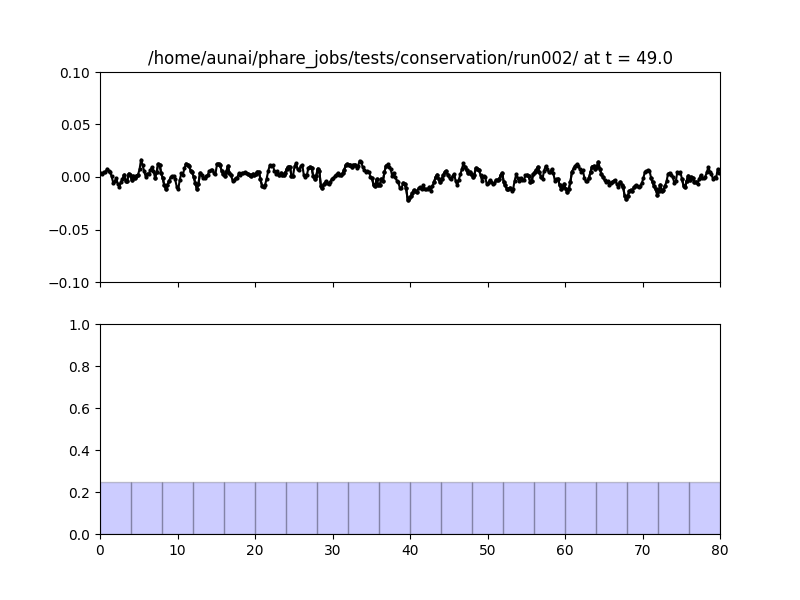

(<Figure size 800x600 with 2 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f44fa6c4e20>)

In [162]:
plot_job(r.path, 49.000000, "By", xlim=(0,80), marker="none", ylim=(-0.1,0.1))

## Run003

In [314]:
r = Run("/home/aunai/phare_jobs/tests/conservation/run003/")

In [315]:
times = get_times(r.path+"/EM_B.h5")
Bnrj = np.zeros_like(times)
K = np.zeros_like(times)
for it,t in enumerate(times):
    B = r.GetB(t)
    protons = r.GetParticles(t, "protons")
    Bnrj[it] = mag_energy(B)
    K[it] = total_kinetic(protons)

<IPython.core.display.Javascript object>


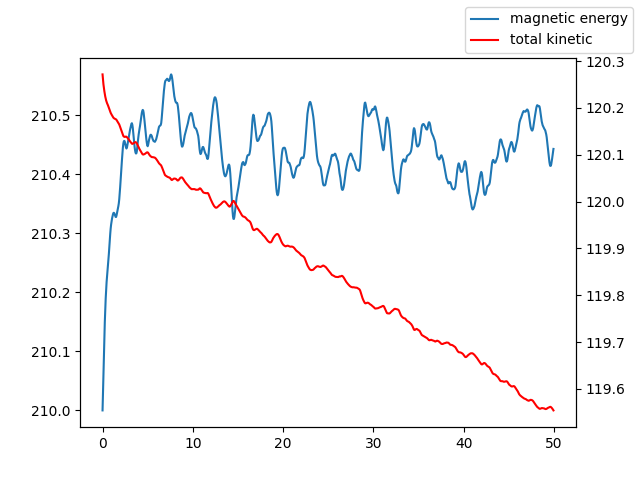

In [316]:
fig, ax1 =plt.subplots()
ax1.plot(times, Bnrj, label="magnetic energy")
ax2 = plt.twinx(ax1)
ax2.plot(times, K, label="total kinetic", color="r")
fig.legend()
#ax.set_yscale("log")

<IPython.core.display.Javascript object>


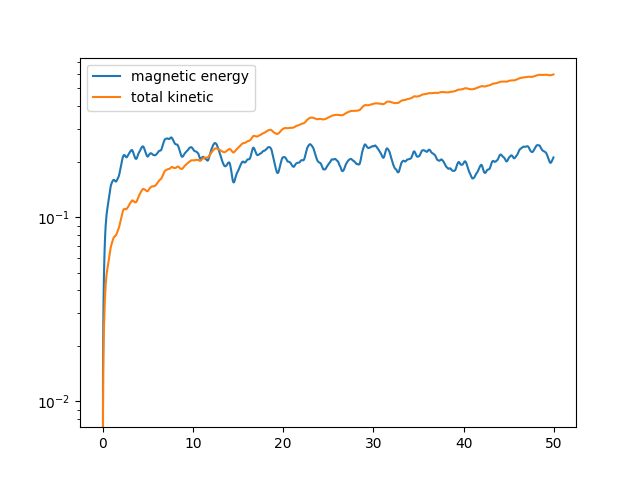

In [317]:
fig, ax = plt.subplots()
ax.plot(times, np.abs(Bnrj-Bnrj[0])/Bnrj[0]*100, label="magnetic energy")
ax.plot(times, np.abs(K-K[0])/K[0]*100, label="total kinetic")
ax.legend()
ax.set_yscale("log")